# 实现GPT - 2模型

## 前置

### 配置参数

In [1]:
GPT_CONFIG_124M = {
	"vocab_size": 50257,      # 50257个单词的词汇表
    "context_length": 1024,   # 最大输入向量数
    "emb_dim": 768,           # 嵌入维度
    "n_heads": 12,            # 注意力头数
    "n_layers": 12,           # transformer数量
    "drop_rate": 0.1,         # 丢弃率10%
    "qkv_bias": False         # 偏向量
}

### Token embeddings

In [2]:
import tiktoken
import torch

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## GPT backbone

### DummyGPTModel：

![image.png](https://ressmatthew-picture-cloud-storage.oss-cn-hangzhou.aliyuncs.com/img/202408140041002.png)

In [3]:
import torch
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 标记和位置嵌入
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Dropout
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # Transformer 模块
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # 最终归一化
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 线性输出层
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False)
    # 数据流
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits    
 
 # Transformer 模块 
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x

# 归一化 模块
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x


#### 测试

In [4]:

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer normalization

### 工作原理

* 主要思想：调整神经网络层的激活（输出），使其为单位方差（平均值为0，方差为1）。
* 作用：加快收敛速度，确保一致、可靠的训练。
* 应用：多头注意模块之前和之后，最终输出层之间。

#### exp

![image.png](https://ressmatthew-picture-cloud-storage.oss-cn-hangzhou.aliyuncs.com/img/202408141333215.png)

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) # 2 * 5
# 一个 5 * 6 线性层和一个非线性激活函数 ReLU
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out.shape)
print(out)

torch.Size([2, 6])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


ReLU函数：
![image.png](https://ressmatthew-picture-cloud-storage.oss-cn-hangzhou.aliyuncs.com/img/202408141350626.png)

In [6]:
# 检查均值 mean 和方差 var

# keepdim保持输出维度与输入维度相同
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
# 归一化

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[2.9802e-08],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# 关闭科学记数，提高可读性
torch.set_printoptions(sci_mode=False)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### DummyLayerNorm:

归一化公式：
$$ y=\frac{x-E[x]}{\sqrt{Var[x]+\epsilon}}\mathrm{~*~}\gamma+\beta $$

* $\epsilon$: eps是小常数，防止分母为0；
* 两个可训练参数（与输入维度相同）
    * $\gamma$: scale
    * $\beta$: shift

In [9]:
import torch.nn as nn

# 归一化 模块
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        # unbiased=False 
        # 除以 n 为了与GPT-2的归一化层兼容
        # 有的采用贝塞尔校正，是除以 n-1
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#### 测试

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GELU activation

### 激活函数

#### 工作原理

* 引入非线性：模拟复杂的函数关系
* 加速训练：区间线性
    * ReLU正区间线性
* 防止梯度消失/爆炸：输入值极端梯度接近于零
    * Sigmoid
* 实现稀疏性：减少计算量并提高模型的泛化能力

#### ReLU函数（整流线性单位函数）

![image.png](https://ressmatthew-picture-cloud-storage.oss-cn-hangzhou.aliyuncs.com/img/202408141350626.png)

#### GELU函数（高斯误差线性单元函数）

##### 公式

$$ GELU(x)=x \Phi(x) $$

其中 $ \Phi(x) $ 是标准高斯分布函数。

$$ GELU(x) \approx 0.5 \cdot x \cdot (1 + \tanh[\sqrt{(2/\pi)} \cdot (x + 0.044715 \cdot x^3)]) $$

##### 代码

In [11]:
import torch
from torch import nn

# GELU 激活函数
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

##### 绘制

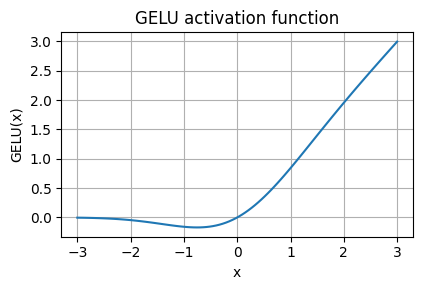

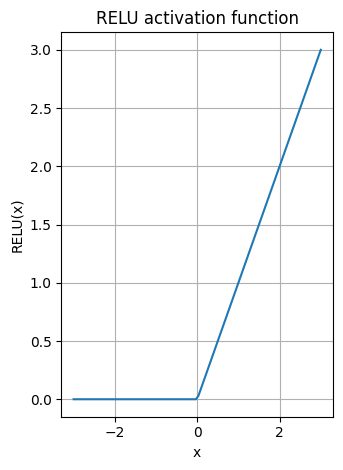

In [12]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### SwiGLU（Sigmoid-权重线性单元函数）

## Feed forward network

#### 代码 - FeedForward

In [13]:
# 用 GELU 实现一个小型神经网络模块
import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 两个线性层和一个GELU激活函数
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
 
    def forward(self, x):
        return self.layers(x)

数据流图：

![image.png](https://ressmatthew-picture-cloud-storage.oss-cn-hangzhou.aliyuncs.com/img/202408141605687.png)

#### 测试

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])
